# ZID: Z5532140 
# Full Name: Haocheng Yang

# Part 1

## Part1 Q1

### Part 1 - Question 1: Cleaning and Evaluation Fixes

1.  **Over-aggressive Regex Cleaning**
It will remove all non-letter characters, including useful punctuation, numbers, emojis, musical genres such as "R&B", hyphens of "hip-hop", etc.
**Fix**: I use a single revised regular expression `[^a-zA-Z0-9\s]` to retain letters, numbers, hyphens, and apostrophes.
It keeps meaningful phrases in lyrics and metadata.

2.  **Single Train-Test Split Instead of Cross-Validation**
The tutorial uses a single random split, and this is not a good one for performance estimation.

**Solution**: I use **5-fold cross-validation** via `cross_val_score` or `cross_validate`. This provides a more consistent and representative evaluation.


## Part1 Q2

### Data loading

In [1]:
import pandas as pd

df = pd.read_csv("dataset.tsv", sep="\t")

df["document"] = df["artist_name"].fillna("") + " " + \
                 df["track_name"].fillna("") + " " + \
                 df["genre"].fillna("") + " " + \
                 df["lyrics"].fillna("")

df["topic"].value_counts()

topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

### Text cleaning and preprocessing functions

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk_stop_words = set(stopwords.words('english'))
sklearn_stopwords = ENGLISH_STOP_WORDS

def preprocess(text, use_nltk=False, use_scikit_learn=False, use_stem=False, use_lemma=False):
    if pd.isna(text):
            return ''

    text = text.lower()

    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    text = re.sub(r'\s+', ' ', text)

    text = text.strip()

    tokens = word_tokenize(text)  

    if use_nltk:
        tokens = [t for t in tokens if t not in nltk_stop_words]
    if use_scikit_learn:
        tokens = [t for t in tokens if t not in sklearn_stopwords]

    if use_stem:
        tokens = [stemmer.stem(t) for t in tokens]
    if use_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
        
    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yanghaocheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanghaocheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yanghaocheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Define the preprocessing combination

In [3]:
preprocessing_configs = {
    'base (lower + nltk_stopwords)': lambda x: preprocess(x, True, False, False, False),
    'base (lower + sklearn_stopwords)': lambda x: preprocess(x, False, True, False, False),

    'stem + nltk_stopwords': lambda x: preprocess(x, True, False, True, False),
    'stem + sklearn_stopwords': lambda x: preprocess(x, False, True, True, False),

    'lemma + nltk_stopwords': lambda x: preprocess(x, True, False, False, True),
    'lemma + sklearn_stopwords': lambda x: preprocess(x, False, True, False, True),

    'stem + lemma + nltk_stopwords': lambda x: preprocess(x, True, False, True, True),
    'stem + lemma + sklearn_stopwords': lambda x: preprocess(x, False, True, True, True),
}

### Evaluate the preprocessing combination

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# MultinomialNB + CountVectorizer + 5-fold
def evaluate_pipeline(text_series, labels, preproc_func):
    cleaned = text_series.apply(preproc_func)
    X = CountVectorizer().fit_transform(cleaned)
    y = labels
    model = MultinomialNB()
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return scores.mean()

results = []
for name, func in preprocessing_configs.items():
    print(f"Evaluating: {name}")
    acc = evaluate_pipeline(df["document"], df["topic"], func)
    results.append((name, acc))

df_results = pd.DataFrame(results, columns=["Preprocessing Strategy", "Average Accuracy"])
df_results = df_results.sort_values(by="Average Accuracy", ascending=False)
print(df_results.to_string(index=False))

Evaluating: base (lower + nltk_stopwords)
Evaluating: base (lower + sklearn_stopwords)
Evaluating: stem + nltk_stopwords
Evaluating: stem + sklearn_stopwords
Evaluating: lemma + nltk_stopwords
Evaluating: lemma + sklearn_stopwords
Evaluating: stem + lemma + nltk_stopwords
Evaluating: stem + lemma + sklearn_stopwords
          Preprocessing Strategy  Average Accuracy
   stem + lemma + nltk_stopwords          0.795333
           stem + nltk_stopwords          0.794667
          lemma + nltk_stopwords          0.791333
   base (lower + nltk_stopwords)          0.789333
base (lower + sklearn_stopwords)          0.786667
        stem + sklearn_stopwords          0.784000
stem + lemma + sklearn_stopwords          0.784000
       lemma + sklearn_stopwords          0.783333


Different Naive Bayes preprocessing methods were compared using five cross-validations. 'stem + lemma + nltk_stopwords' was best with being 79.53%. 

For the current task, lemmatization can retain more semantic consistency and improve the matching quality

Therefore, I choose **'stem + lemma + nltk_stopwords'** as the best preprocessing scheme. This is the best compromise between performance and simplicity.

## Part 1 Q3

### Import and Preparation

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import numpy as np
import pandas as pd

df["clean_text"] = df["document"].apply(lambda x: preprocess(x, True, False, True, True))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["clean_text"])
y = df["topic"]

### Cross-validation + multi-metric evaluation


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

bnb = BernoulliNB()
mnb = MultinomialNB()

bnb_scores = cross_validate(bnb, X, y, cv=5, scoring=scoring)
mnb_scores = cross_validate(mnb, X, y, cv=5, scoring=scoring)

### Result summary and presentation

In [7]:
results_df = pd.DataFrame({
    "Metric": ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1'],
    "BernoulliNB": [
        np.mean(bnb_scores['test_accuracy']),
        np.mean(bnb_scores['test_precision_macro']),
        np.mean(bnb_scores['test_recall_macro']),
        np.mean(bnb_scores['test_f1_macro'])
    ],
    "MultinomialNB": [
        np.mean(mnb_scores['test_accuracy']),
        np.mean(mnb_scores['test_precision_macro']),
        np.mean(mnb_scores['test_recall_macro']),
        np.mean(mnb_scores['test_f1_macro'])
    ]
})

print("=== BNB vs MNB Classification Metrics ===")
print(results_df)

=== BNB vs MNB Classification Metrics ===
            Metric  BernoulliNB  MultinomialNB
0         Accuracy     0.524000       0.795333
1  Macro Precision     0.384789       0.768120
2     Macro Recall     0.382248       0.713958
3         Macro F1     0.342412       0.729234


### The basis for comparison and selection of model evaluation metrics

To compare BNB and MNB's performance in the task of "topic classification", I selected the following four indicators of evaluation:

**Accuracy** : It determines the proportion of correct predictions by the overall model. Assuming that category distribution is roughly balanced, it is a good evaluation metric.

**Macro Precision** : Calculate the precision of each category separately and then take the average value. This metric gives each category equal weight, which can prevent the model from being too biased toward large categories.

**Macro Recall** : Calculate the recall rate for each category separately and then take the average. This metric helps in calculating whether the model is able to cover samples of all categories or not.

**Macro F1 score** : Harmonic mean of precision and recall, it is used to measure the overall robustness of the model, especially suitable for multi-category tasks.

Get by checking the number of different types of samples by `df["topic"].value_counts()` :

dark: 490

sadness: 376

personal: 347

lifestyle: 205

emotion: 82

Among them, the emotion category is significantly fewer. Therefore, if the accuracy rate is used alone, the model would be willing to favor the more frequently predicted category and neglect the minority ones. In short, although the accuracy rate can be used as a general benchmark, I mainly rely on the `Macro-F1 score` to judge whether the final model is better or worse than others.

It can be seen from the BNB vs MNB Classification Metrics that in all of the metrics used for evaluation, MultinomialNB performs better than BernoulliNB.

## Part 1 Q4

### Define the variable vectorizer and the evaluation function

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
def evaluate_with_metrics(text_series, labels, max_features, isMnb):
    vectorizer = CountVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text_series)

    if isMnb:
        model = MultinomialNB()
    else:
        model = BernoulliNB()

    scoring = {
        'accuracy': 'accuracy',
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
    }

    scores = cross_validate(model, X, labels, cv=5, scoring=scoring)

    model.fit(X, labels)
    y_pred = model.predict(X)
    print("Confusion Matrix:\n", confusion_matrix(labels, y_pred, labels=model.classes_))
    print("Classification Report:\n", classification_report(labels, y_pred))

    return {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision_macro'].mean(),
        'recall': scores['test_recall_macro'].mean(),
        'f1': scores['test_f1_macro'].mean()
    }

### Experiment with multiple values of N and collect the results

In [9]:
N_values = [200, 300, 400, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, None]
results_Mnb = []
results_Bnb = []

for n in N_values:
    print(f"Evaluating MNB max_features = {n}")
    acc_Mnb = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=n, isMnb=True)['accuracy']
    label_Mnb = "No Limit" if n is None else n
    results_Mnb.append((label_Mnb, acc_Mnb))

    
    print(f"Evaluating BNB max_features = {n}")
    acc_Bnb = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=n, isMnb=False)['accuracy']
    label_Bnb = "No Limit" if n is None else n
    results_Bnb.append((label_Bnb, acc_Bnb))

results_df_Mnb = pd.DataFrame(results_Mnb, columns=["Top-N Features", "Accuracy"])
results_df_Bnb = pd.DataFrame(results_Bnb, columns=["Top-N Features", "Accuracy"])


Evaluating MNB max_features = 200
Confusion Matrix:
 [[417   8   9  25  31]
 [  4  67   3   1   7]
 [ 14   2 184   3   2]
 [ 23   3   4 310   7]
 [ 15   1   5  11 344]]
Classification Report:
               precision    recall  f1-score   support

        dark       0.88      0.85      0.87       490
     emotion       0.83      0.82      0.82        82
   lifestyle       0.90      0.90      0.90       205
    personal       0.89      0.89      0.89       347
     sadness       0.88      0.91      0.90       376

    accuracy                           0.88      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.88      0.88      0.88      1500

Evaluating BNB max_features = 200
Confusion Matrix:
 [[378  12  23  47  30]
 [ 13  35  13   9  12]
 [ 28   3 141  13  20]
 [ 61   9  20 235  22]
 [ 53  11  33  24 255]]
Classification Report:
               precision    recall  f1-score   support

        dark       0.71      0.77      0.74       490
     emotion    

### Result chart + Best N description

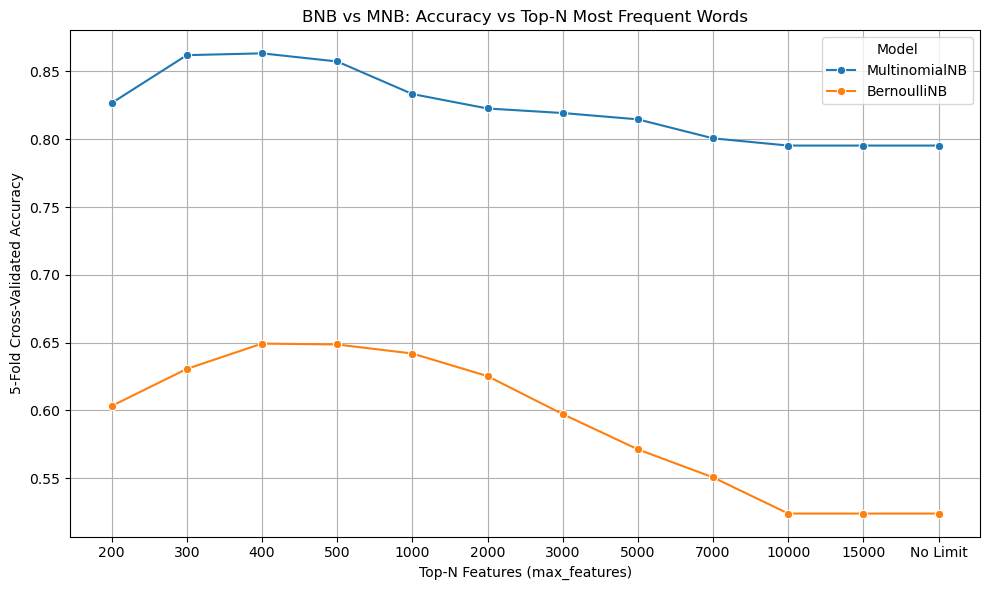

MNB Accuracy Results:
   Top-N Features  Accuracy          Model
2             400  0.863333  MultinomialNB
1             300  0.862000  MultinomialNB
3             500  0.857333  MultinomialNB
4            1000  0.833333  MultinomialNB
0             200  0.826667  MultinomialNB
5            2000  0.822667  MultinomialNB
6            3000  0.819333  MultinomialNB
7            5000  0.814667  MultinomialNB
8            7000  0.800667  MultinomialNB
9           10000  0.795333  MultinomialNB
10          15000  0.795333  MultinomialNB
11       No Limit  0.795333  MultinomialNB

BNB Accuracy Results:
   Top-N Features  Accuracy        Model
2             400  0.649333  BernoulliNB
3             500  0.648667  BernoulliNB
4            1000  0.642000  BernoulliNB
1             300  0.630667  BernoulliNB
5            2000  0.625333  BernoulliNB
0             200  0.603333  BernoulliNB
6            3000  0.597333  BernoulliNB
7            5000  0.571333  BernoulliNB
8            7000  0.550667

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df_Mnb["Model"] = "MultinomialNB"
results_df_Bnb["Model"] = "BernoulliNB"
plot_df = pd.concat([results_df_Mnb, results_df_Bnb], ignore_index=True)

plot_df["Top-N Features"] = plot_df["Top-N Features"].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x="Top-N Features", y="Accuracy", hue="Model", marker='o')
plt.title("BNB vs MNB: Accuracy vs Top-N Most Frequent Words")
plt.xlabel("Top-N Features (max_features)")
plt.ylabel("5-Fold Cross-Validated Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

print("MNB Accuracy Results:")
print(results_df_Mnb.sort_values(by="Accuracy", ascending=False))
print("\nBNB Accuracy Results:")
print(results_df_Bnb.sort_values(by="Accuracy", ascending=False))


#### Top-N feature number optimal selection and experimental results
The control of the number of most common words preserved in the process of text vectorization is obtained through `CountVectorizer(max_features=N)`, and 50% cross-validation on MultinomialNB (MNB) and BernoulliNB (BNB) is conducted respectively under different N values. The result looks like above.

#### Experimental results and conclusions:
MNB outperforms BNB across all N values and achieves the highest rate of accuracy, i.e., 86.3%, when Top-N = 400.

The performance of BNB was overall very bad. It performed best (64.9%) when N = 400, but was significantly worse than MNB.

#### The final selection
**Top-N Features =400**, as a constant parameter to `CountVectorizer(max_features=400)` used in subsequent operations.

## Part 1 Q5

### Logistic Regression Method

Logistic regression is a linear classifier with extensive applications in multi-classification problems, and its output is the probability of a class. In contrast to Naive Bayes's conditional independent hypothesis, logistic regression has the ability to model the linear correlation between classes and features by learning the weights, and typically achieves incredible performance in tasks such as text classification and advertisement click-through rate prediction.

The reasons why logistic regression is chosen for this data set are:
- The feature dimension is relatively high and sparse once the lyrics are vectorized by the word bag;
- Logistic regression can remain effective in high-dimensional sparse feature spaces;
- It is not sensitive to collinearity among features and can accept word frequency vector input.

Therefore, I choose to utilize logistic regression as the baseline model.

### Model import and data vectorization

In [11]:
from sklearn.linear_model import LogisticRegression

vectorizer_count = CountVectorizer(max_features=400)

X_lr = vectorizer_count.fit_transform(df["clean_text"])
y = df["topic"]

The use of the logistic regression model is achieved through `from sklearn.linear_model import LogisticRegression`. 

### Model tuning

In [12]:
C_values = [0.01, 0.1, 0.5, 1, 2, 5, 10, 20]
results = []
for c in C_values:
    print(f"Evaluating Logistic Regression with C={c}")
    model = LogisticRegression(C=c, solver='liblinear', max_iter=1000, class_weight='balanced')
    scores = cross_validate(model, X_lr, y, cv=5, scoring=scoring)
    results.append({
        "C": c,
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision_macro']),
        "Recall": np.mean(scores['test_recall_macro']),
        "F1": np.mean(scores['test_f1_macro'])
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1", ascending=False))

Evaluating Logistic Regression with C=0.01
Evaluating Logistic Regression with C=0.1
Evaluating Logistic Regression with C=0.5
Evaluating Logistic Regression with C=1
Evaluating Logistic Regression with C=2
Evaluating Logistic Regression with C=5
Evaluating Logistic Regression with C=10
Evaluating Logistic Regression with C=20
       C  Accuracy  Precision    Recall        F1
1   0.10  0.883333   0.871378  0.866155  0.867820
0   0.01  0.877333   0.861756  0.866226  0.863328
2   0.50  0.878000   0.866195  0.856960  0.860877
3   1.00  0.874000   0.857401  0.851430  0.853584
4   2.00  0.870000   0.852938  0.843346  0.847255
5   5.00  0.868000   0.848887  0.842481  0.844856
6  10.00  0.861333   0.843689  0.834542  0.837652
7  20.00  0.857333   0.838970  0.828705  0.832321


Due to the limited dataset and sparsity of features, parameters are given as follows:
- **solver='liblinear'** : Suitable for small datasets and can deal with L2 regularization;
- **max_iter=1000** : Ensure that iterations are sufficiently large so that the model converges.
- **C=0.1** : Strong regularization strength with a lower value of C is taken in this case to control model complexity and avoid overfitting for high-dimensional sparse text representations. This setting led to the best Macro-F1 performance during cross-validation and thus was selected as the final model parameter.

Hypothesis:
Compared to the Naive Bayes model (BNB and MNB), **Logistic Regression may have a higher macro average F1 score** in lyrics topic classification task, as it doesn't assume feature independence and can better model the conconnectives in context, being suitable for sparse high-dimensional feature Spaces.

Lastly, I will use cross-validation and the same preprocessing method to compare the accuracy and macro average F1 score of the three models to determine whether this hypothesis holds true.

### Set cross-validation scoring metrics and conduct evaluations


In [13]:
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', C=0.1, class_weight='balanced')
lr_scores = cross_validate(lr_model, X_lr, y, cv=5, scoring=scoring)

mnb_acc = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=True)['accuracy']
mnb_precesion = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=True)['precision']
mnb_recall = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=True)['recall']
mnb_f1 = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=True)['f1']

bnb_acc = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=False)['accuracy']
bnb_precesion = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=False)['precision']
bnb_recall = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=False)['recall']
bnb_f1 = evaluate_with_metrics(df["clean_text"], df["topic"], max_features=400, isMnb=False)['f1']

Confusion Matrix:
 [[463   3   4   7  13]
 [  2  75   2   2   1]
 [  7   1 190   3   4]
 [  7   1   4 333   2]
 [ 12   1   3   4 356]]
Classification Report:
               precision    recall  f1-score   support

        dark       0.94      0.94      0.94       490
     emotion       0.93      0.91      0.92        82
   lifestyle       0.94      0.93      0.93       205
    personal       0.95      0.96      0.96       347
     sadness       0.95      0.95      0.95       376

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500

Confusion Matrix:
 [[463   3   4   7  13]
 [  2  75   2   2   1]
 [  7   1 190   3   4]
 [  7   1   4 333   2]
 [ 12   1   3   4 356]]
Classification Report:
               precision    recall  f1-score   support

        dark       0.94      0.94      0.94       490
     emotion       0.93      0.91      0.92        82
   lifestyle       0.94      0

### The results were summarized and compared with BNB/MNB

In [14]:
final_comparison = pd.DataFrame({
    "Metric": ['Accuracy', 'Macro F1'],
    "Logistic Regression": [
        np.mean(lr_scores['test_accuracy']),
        np.mean(lr_scores['test_f1_macro'])
    ],
    "MultinomialNB": [mnb_acc, mnb_f1],
    "BernoulliNB": [bnb_acc, bnb_f1]
})

final_comparison

,Metric,Logistic Regression,MultinomialNB,BernoulliNB
0,Accuracy,0.883333,0.863333,0.649333
1,Macro F1,0.867820,0.844955,0.564765


### Hypothesis Verification

According to the comparison of final score, it is found that compared to BNB and MNB, **logistic regression can perform better on Macro-F1 score and Accuracy, especially with stronger generalization power in the high-dimensional sparse feature space.** The assumption holds. A higher Macro-F1 score implies that it maintains a more balanced performance among various categories (including subcategories). The Accuracy also gets the best value, implying that its overall prediction performance is the best.

### Final model configuration

- Preprocessing text: **lower + nltk + stemming + punkt tokenizer**
- Features to set: **max_features=400**
- Classifier to use: **Logistic Regression**
- Strength of regularization: **C = 0.1**

It does its best or less than optimally on all evaluation criteria. It possesses good interpretability, computational efficiency and generalization capability, and is the "overall best" topic classification model solution for this task.

# Part 2

## Part2 Q1

### Load data & Build the training test set

In [15]:
train_data = df.iloc[:750].copy()  
train_data["document"] = train_data["artist_name"].fillna("") + " " + \
                 train_data["track_name"].fillna("") + " " + \
                 train_data["genre"].fillna("") + " " + \
                 train_data["lyrics"].fillna("")
train_data.reset_index(drop=True, inplace=True)
train_data["clean_lyrics"] = train_data["lyrics"].apply(lambda x: preprocess(x, True, False, True, True))
train_data["clean_text"] = train_data["document"].apply(lambda x: preprocess(x, True, False, True, True))


test_data = df.iloc[750:1000].copy() 
test_data["document"] = test_data["artist_name"].fillna("") + " " + \
                 test_data["track_name"].fillna("") + " " + \
                 test_data["genre"].fillna("") + " " + \
                 test_data["lyrics"].fillna("")
test_data.reset_index(drop=True, inplace=True)
test_data["clean_lyrics"] = test_data["lyrics"].apply(lambda x: preprocess(x, True, False, True, True))
test_data["clean_text"] = test_data["document"].apply(lambda x: preprocess(x, True, False, True, True))

### Save vectorizer and model for Part2

In [16]:
from joblib import dump
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer

nltk_stop_words_list = stopwords.words('english')  

vectorizer_tfidf = TfidfVectorizer(max_features = 400)
vectorizer_tfidf.fit(train_data["clean_text"])
dump(vectorizer_tfidf, 'best_vectorizer_tfidf.joblib')
best_vectorizer_tfidf = load('best_vectorizer_tfidf.joblib')

X_lr = vectorizer_tfidf.fit_transform(train_data["clean_text"])
y = train_data["topic"]
lr_model.fit(X_lr, y)
dump(lr_model, 'best_model.joblib')
best_clf = load('best_model.joblib')

### Use the best classifier in Part 1 to predict the topic tags of the training set

In [17]:
X_train_vec = best_vectorizer_tfidf.transform(train_data["clean_text"])
train_data.loc[:, "predicted_topic"] = best_clf.predict(X_train_vec)

### Read the user's keyword file and find out the songs in the training set that each user likes

In [18]:
def preprocess_keywords(keywords):
    return set(preprocess(' '.join(keywords), True, False, True, True).split())

def load_user_keywords(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    topic_keywords = {}
    for line in lines:
        topic, keywords = line.strip().split('\t')
        topic = topic.strip().lower()
        keyword_list = re.findall(r'\w+', keywords.lower())
        keyword_list = preprocess_keywords(keyword_list)
        topic_keywords[topic] = keyword_list
    return topic_keywords


user1_keywords = load_user_keywords('user1.tsv')
user2_keywords = load_user_keywords('user2.tsv')

# Determine whether a user likes a certain song
def liked_songs(user_keywords, df):
    liked = {topic: [] for topic in user_keywords} 
    for _, row in df.iterrows():
        topic = row['predicted_topic']
        lyric = row['clean_lyrics'].lower()
        if topic in user_keywords:
            if any(kw in lyric for kw in user_keywords[topic]):
                liked[topic].append(lyric)
    return liked


user1_liked = liked_songs(user1_keywords, train_data)
user2_liked = liked_songs(user2_keywords, train_data)

### Build user profiles

In [19]:
def build_user_profile(liked_dict, vec):
    corpus = []
    for topic in ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']:
        topic_text = ' '.join(liked_dict.get(topic, [])) 
        corpus.append(topic_text)
    tfidf_matrix = vec.transform(corpus)
    return tfidf_matrix

user1_profile = build_user_profile(user1_liked, best_vectorizer_tfidf)
user2_profile = build_user_profile(user2_liked, best_vectorizer_tfidf)

### Output the top 20 keywords for each topic in the user profile

In [20]:
def print_top_keywords(tfidf_matrix, vec, user_name):
    print(f"\n===== {user_name} Top 20 keywords for user profiling=====\n")
    topics = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
    for idx, topic in enumerate(topics):
        vector = tfidf_matrix[idx].toarray().flatten()
        top_n = np.argsort(vector)[::-1][:20]
        keywords = [vec.get_feature_names_out()[j] for j in top_n if vector[j] > 0]
        print(f"{topic.capitalize()}: {keywords}\n")

print_top_keywords(user1_profile, best_vectorizer_tfidf, 'User 1')
print_top_keywords(user2_profile, best_vectorizer_tfidf, 'User 2')


===== User 1 Top 20 keywords for user profiling=====

Dark: ['fight', 'blood', 'grind', 'like', 'na', 'stand', 'gon', 'know', 'kill', 'come', 'hear', 'beat', 'black', 'hand', 'tell', 'teach', 'rise', 'yeah', 'build', 'pain']

Emotion: ['good', 'touch', 'feel', 'hold', 'feelin', 'year', 'kiss', 'vibe', 'morn', 'miss', 'want', 'luck', 'go', 'lovin', 'lip', 'sunris', 'know', 'light', 'caus', 'na']

Lifestyle: ['tonight', 'song', 'night', 'sing', 'home', 'come', 'stranger', 'long', 'time', 'right', 'wait', 'spoil', 'tire', 'na', 'wan', 'telephon', 'struggl', 'play', 'mind', 'babi']

Personal: ['life', 'live', 'chang', 'world', 'ordinari', 'na', 'thank', 'dream', 'know', 'yeah', 'lord', 'wan', 'like', 'thing', 'time', 'think', 'learn', 'oohoohoohooh', 'grow', 'need']

Sadness: ['tear', 'break', 'babi', 'fall', 'cri', 'heart', 'away', 'woah', 'na', 'hurt', 'know', 'wish', 'think', 'apart', 'want', 'feel', 'wan', 'place', 'leav', 'caus']


===== User 2 Top 20 keywords for user profiling=====

#### User 1 Profile Analysis

- **Dark**: Keywords such as *"fight"*, *"blood"*, *"kill"*, and *"pain"* convey strong themes of violence and conflict, which are characteristic of darker lyrical content. This vector indicates heavy, possibly aggressive songs.
- **Emotion**: Words such as *"touch"*, *"feel"*, *"kiss"*, *"vibe"*, and *"morning"* express a strong emotional and sensual focus with a touch of sensitivity to relational or romantic content.
- **Lifestyle**: Words such as *"tonight"*, *"night"*, *"home"*, and *"song"* imply focus on social or contemplative topics, usually associated with lifestyle and daily life.
- **Personal**: With oft-repeated words like *"life"*, *"change"*, *"dream"*, and *"learn"*, this vector represents songs that talk of self-improvement, introspection, and existential issues.
- **Sadness**: Words like *"tear"*, *"break"*, *"cry"*, *"hurt"*, and *"heart"* are strongly linked with the motifs of loss and vulnerability, suggesting deep involvement with sad content.

#### User 2 Profile Analysis

- **Emotion**: Shares many keywords with User 1, including *"feel"*, *"kiss"*, *"vibe"*, and *"lovin"*, confirming that this user is likely very focused on relational and sensual aspects of music.
- **Sadness**: The presence of *"tear"*, *"hurt"*, *"cry"*, and *"heart"* indicates alignment with emotionally vulnerable and melancholic songs.

#### Summary

Both users' profiles appear to be consistent and interpretable:

- **User 1** has a rich and diverse emotional life, with participation in all five themes.
- **User 2** has a more selective emotional life, with a focus on romantic and sad content.


### Define User3 and customize keywords to build an interest profile

In [21]:
user3_keywords = {
    'dark': {"night", "club", "dance", "party"},
    'emotion': {"love", "heart", "baby", "kiss"},
    'lifestyle': {"money", "dream", "city", "street"},
    'personal': {"diary", "life", "alone", "feel"},
    'sadness': {"tears", "cry", "hurt", "pain"}
}

user3_keywords = {topic: preprocess_keywords(words) for topic, words in user3_keywords.items()}
user3_liked = liked_songs(user3_keywords, train_data)
user3_profile = build_user_profile(user3_liked, best_vectorizer_tfidf)
print_top_keywords(user3_profile, best_vectorizer_tfidf, 'User 3')



===== User 3 Top 20 keywords for user profiling=====

Dark: ['closer', 'fight', 'black', 'night', 'shout', 'come', 'na', 'welcom', 'follow', 'oooh', 'readi', 'gon', 'ring', 'stand', 'head', 'light', 'ghost', 'like', 'know', 'evil']

Emotion: ['good', 'go', 'touch', 'hold', 'feel', 'feelin', 'kiss', 'vibe', 'morn', 'miss', 'want', 'luck', 'lovin', 'lip', 'sunris', 'know', 'babi', 'na', 'wait', 'like']

Lifestyle: ['spoil', 'song', 'play', 'home', 'night', 'come', 'right', 'wait', 'want', 'time', 'make', 'belong', 'root', 'know', 'summer', 'thought', 'long', 'yeah', 'dear', 'na']

Personal: ['life', 'live', 'chang', 'world', 'ordinari', 'na', 'know', 'yeah', 'lord', 'give', 'wan', 'like', 'think', 'thing', 'time', 'thank', 'dream', 'oohoohoohooh', 'grow', 'believ']

Sadness: ['break', 'hurt', 'heart', 'fall', 'tear', 'na', 'babi', 'away', 'know', 'wan', 'think', 'caus', 'cri', 'leav', 'like', 'pain', 'yeah', 'feel', 'woah', 'gon']



#### User 3 Profiling Analysis Top 20 Keywords

- **Dark**: Keywords like **"fight"**, **"black"**, **"evil"**, **"ghost"**, and **"shout"**, indicating an interest in violent, foreboding, or rebellious lyrical subject matter. 

- **Emotion**: Words such as **"feel"**, **"touch"**, **"kiss"**, **"vibe"**, **"sunrise"**, and **"miss"** are sensual and romantic in tone. Repetitive usage of the most common emotion-oriented words such as **"babi"**, **"wait"**, and **"want"** assures the emotional interest.

- **Lifestyle**: Words like **"play"**, **"night"**, **"home"**, **"song"**, and **"summer"** with a focus on habit-based, memory-based, or longing-based life. 

- **Personal**: This vector is governed by reflective words: **"life"**, **"live"**, **"dream"**, **"think"**, **"grow"**, and **"believ"**, all of which refer to self-enlargement and reflection themes. 

- **Sadness**: Terms such as **"break"**, **"hurt"**, **"tear"**, **"fall"**, and **"cri"** clearly refer to emotional hurt or vulnerability. Despite the sadness, repetition of terms such as **"babi"** and **"like"** show that even sad songs are romantic in nature.

#### Summary

User 3's profile is an intense emotional investment in music spanning **romantic**, **introspective**, **melancholic**, and **dark/edgy** themes. The keywords reflect a user who would likely be drawn to lyrics conveying deep personal states, complex emotional experiences, and maybe darker aesthetics.


## Part2 Q2

### Training set preprocessing

In [22]:
test_data["clean_text"] = test_data["document"].apply(lambda x: preprocess(x, True, False, True, True))

X_test_vec_tfidf = vectorizer_tfidf.transform(test_data['clean_text'])

test_data.loc[:, 'predicted_topic'] = best_clf.predict(X_test_vec_tfidf)

### Construction of user portraits

In [23]:
from sklearn.preprocessing import normalize
def build_user_profile_m(user_keywords_dict, df, vec, top_m='all'):
    profile = {}
    for topic in ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']:
        liked_lyrics = []
        keywords = user_keywords_dict.get(topic, set())
        if not keywords:
            profile[topic] = vec.transform([''])
            continue
        for _, row in df[df['predicted_topic'] == topic].iterrows():
            lyric = row['clean_lyrics'].lower()
            if any(kw in lyric for kw in keywords):
                liked_lyrics.append(lyric)
        if liked_lyrics:
            text = ' '.join(liked_lyrics)
        else:
            text = ''
        vec_full = vec.transform([text])
        if top_m == 'all':
            vec_selected = vec_full
        else:
            arr = vec_full.toarray()[0]
            top_idx = arr.argsort()[::-1][:top_m]
            masked = np.zeros_like(arr)
            masked[top_idx] = arr[top_idx]
            vec_selected = vec.transform([''])
            vec_selected = vec_selected.multiply(0)
            vec_selected[0, top_idx] = masked[top_idx]
        vec_normalized = normalize(vec_selected, norm='l2')
        profile[topic] = vec_normalized
    return profile

### Build the recommended similarity for each song in the test set

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_scores(user_profile, song_vectors, predicted_topics):
    scores = []
    
    for i, topic in enumerate(predicted_topics):
        song_vec = song_vectors[i:i+1]  
        if topic not in user_profile:
            scores.append(0.0)
            continue
        profile_vec = user_profile[topic]
        
        score = cosine_similarity(profile_vec, song_vec)[0, 0]

        scores.append(score)

    return scores

### The top N songs recommended

In [25]:
def get_top_n_recommendations(df, sim_scores):
    df_copy = df.copy()
    df_copy['similarity'] = sim_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).head(10)
    return df_sorted.reset_index(drop=True)

### Choosing Recommendation Size N

I set the total number of songs to recommend to **N = 10** for this experiment, based on the following considerations:

- **Cognitive Load Management**: The list is kept small so that users are not cognitively burdened with too many recommendations, reducing the quality of the feedback.
- **Realistic User Simulation**: A shorter recommendation list is more consistent with user interaction on real websites (e.g., Spotify), for which preference modeling is more realistic.
- **Evaluation Sensitivity**: A moderate value of N exposes ranking algorithm differences, making measures such as Precision and MAP more revealing.

In total, setting N = 10 is a balance of user experience, ease of evaluation, and system realism.

### Evaluation metrics: Precision@N, Recall@N, F1@N, MAP

In [26]:
def is_song_liked(row, user_keywords):
    topic = row['predicted_topic']
    lyric = row['clean_lyrics'].lower()
    if topic in user_keywords:
        return any(kw in lyric for kw in user_keywords[topic])
    return False

def calc_f1(precision, recall):
    return 2 * precision * recall / (precision + recall + 1e-8)

def calc_map(hits):
    precisions = []
    hit_count = 0
    for i, hit in enumerate(hits):
        if hit:
            hit_count += 1
            precisions.append(hit_count / (i + 1))
    if hit_count == 0:
        return 0.0
    return sum(precisions) / hit_count

def evaluate_recommendations(recommendations, user_keywords, test_df):
    hits = [1 if is_song_liked(row, user_keywords) else 0 for _, row in recommendations.iterrows()]
    # Precision@N   
    precision = sum(hits) / len(hits) if hits else 0

    # Recall@N
    test_df_copy = test_df.copy()
    test_df_copy['is_liked'] = test_df_copy.apply(lambda row: is_song_liked(row, user_keywords), axis=1)
    total_liked_in_test = test_df_copy['is_liked'].sum()
    recall = sum(hits) / total_liked_in_test if total_liked_in_test else 0

    # F1@N
    f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision + recall) > 0 else 0

    # MAP
    precisions = []
    hit_count = 0
    for i, hit in enumerate(hits):
        if hit:
            hit_count += 1
            precisions.append(hit_count / (i + 1))
    map_score = sum(precisions) / hit_count if hit_count > 0 else 0

    return precision, recall, f1, map_score

I use `Precision@N`, `Recall@N`, and `MAP` as metrics. The primary metric is Precision@N, which computes the proportion of relevant items in the recommendation list, since it is the most indicative of recommendation quality. Recall@N is complementary since it computes the proportion of the user's interest that was covered. MAP considers the rank of the relevant items and measures how effective the system is at ranking the recommendations. These metrics collectively provide a comprehensive view of accuracy, coverage, and ranking quality.

### Evaluation

In [27]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

def final_evaluation(M_list, N, user_liked_dicts, train_data, test_data, 
                                  best_vectorizer_tfidf, X_test_vec_tfidf):
    results = []
    for M in M_list:
        for uid, liked_dict in user_liked_dicts.items():
            
            user_profile = build_user_profile_m(liked_dict, train_data, best_vectorizer_tfidf, top_m=M)

            sim_scores = compute_similarity_scores(user_profile, X_test_vec_tfidf, test_data['predicted_topic'])

            topN_df = get_top_n_recommendations(test_data, sim_scores)

            precision, recall, f1, map = evaluate_recommendations(topN_df, liked_dict, test_data)
        
            results.append((uid, M, precision, recall, f1, map))

    df_result = pd.DataFrame(results, columns=['User', 'M', 'Precision', 'Recall', 'F1', 'MAP'])
    return df_result

M_list = [5, 10, 15, 20, 'all']
N = 10
user_liked_dicts = {
    'user1': user1_keywords,
    'user2': user2_keywords,
    'user3': user3_keywords
}

df_result = final_evaluation(
    M_list=M_list,
    N=N,
    user_liked_dicts=user_liked_dicts,
    train_data=train_data,
    test_data=test_data,
    best_vectorizer_tfidf=best_vectorizer_tfidf,
    X_test_vec_tfidf=X_test_vec_tfidf
)

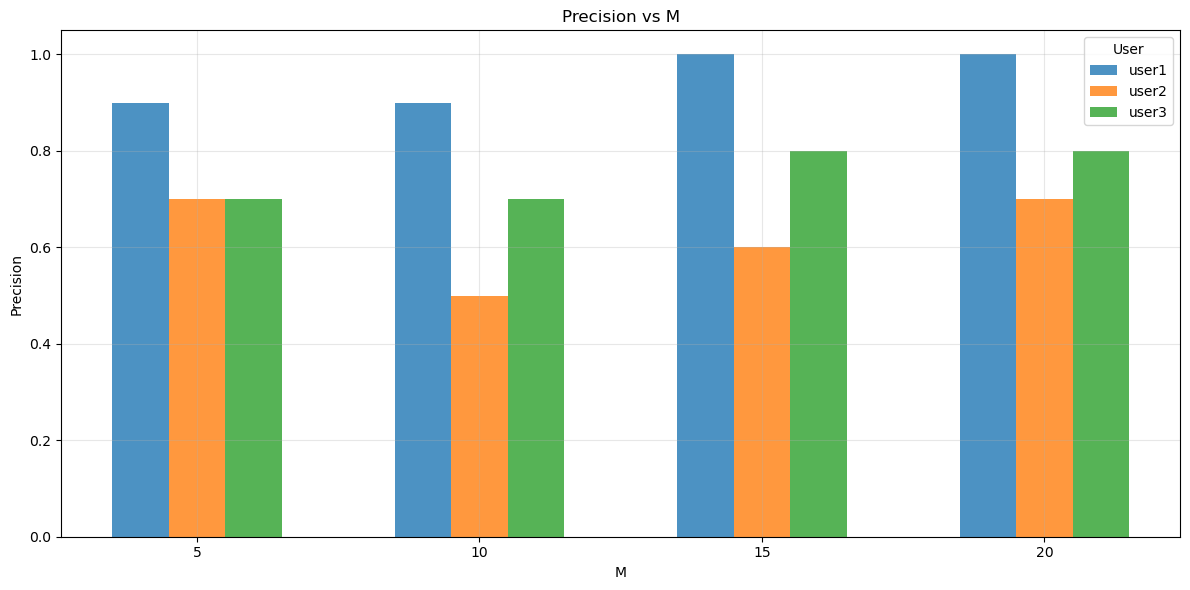

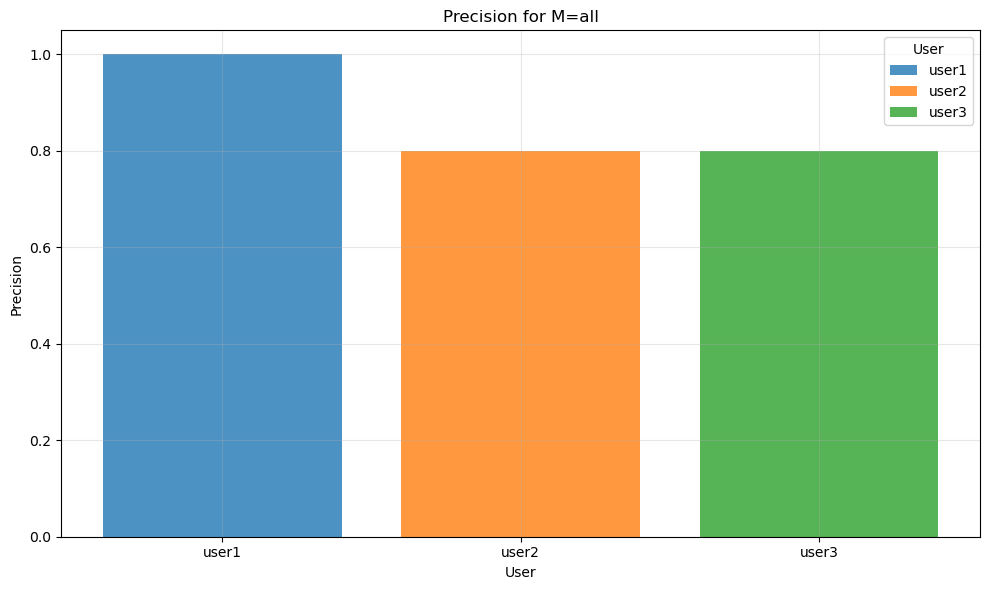

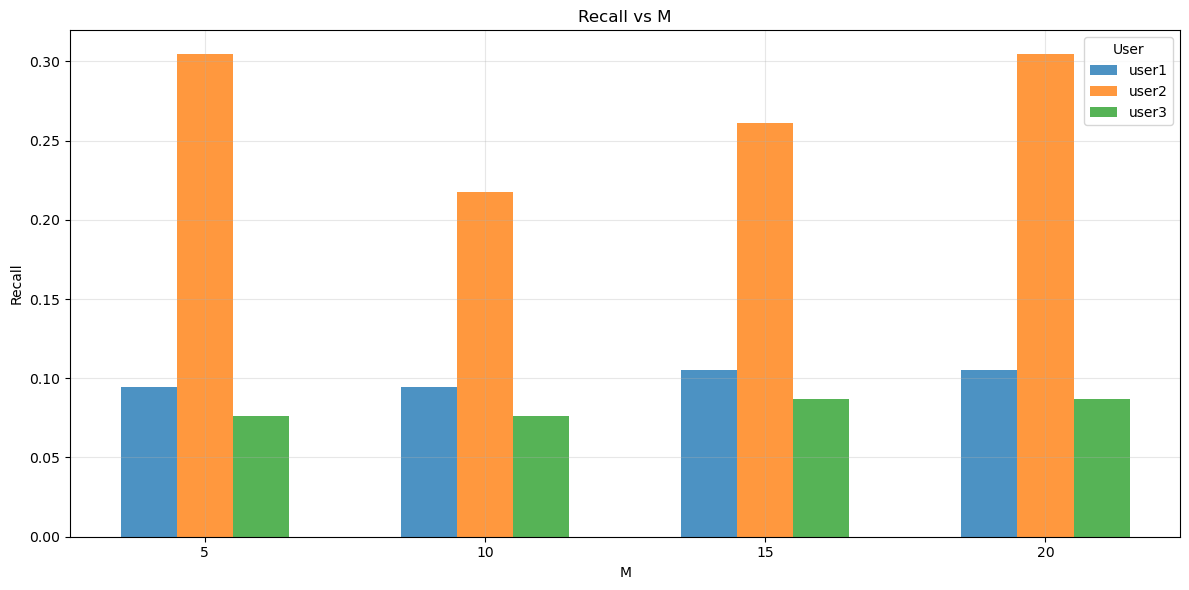

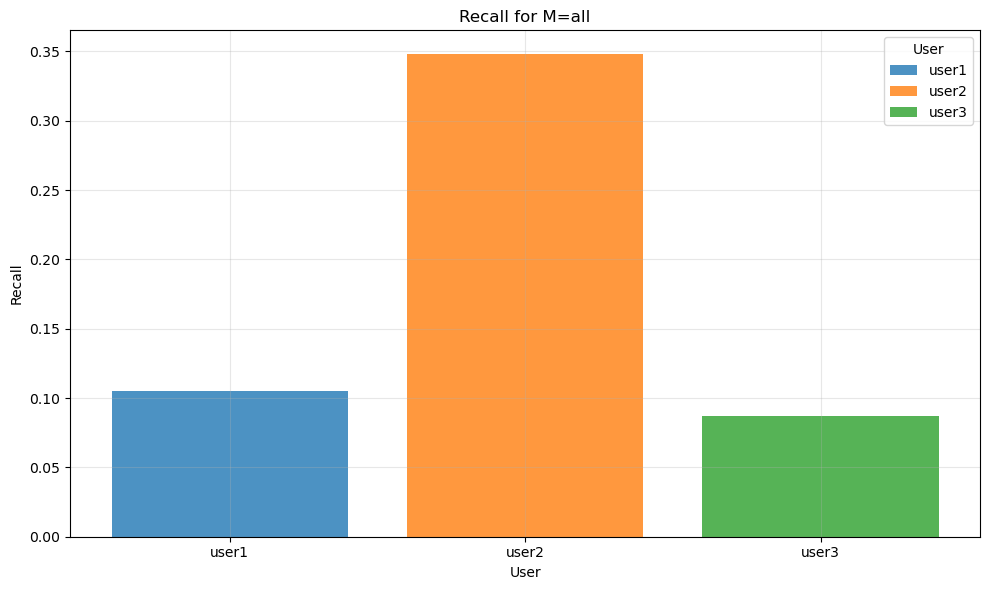

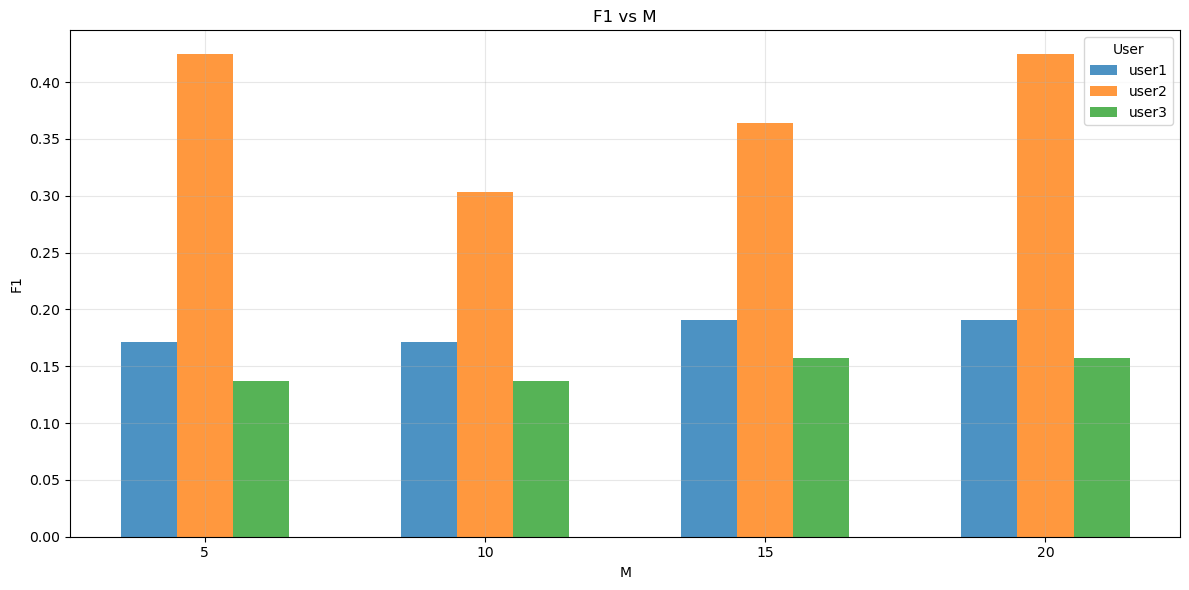

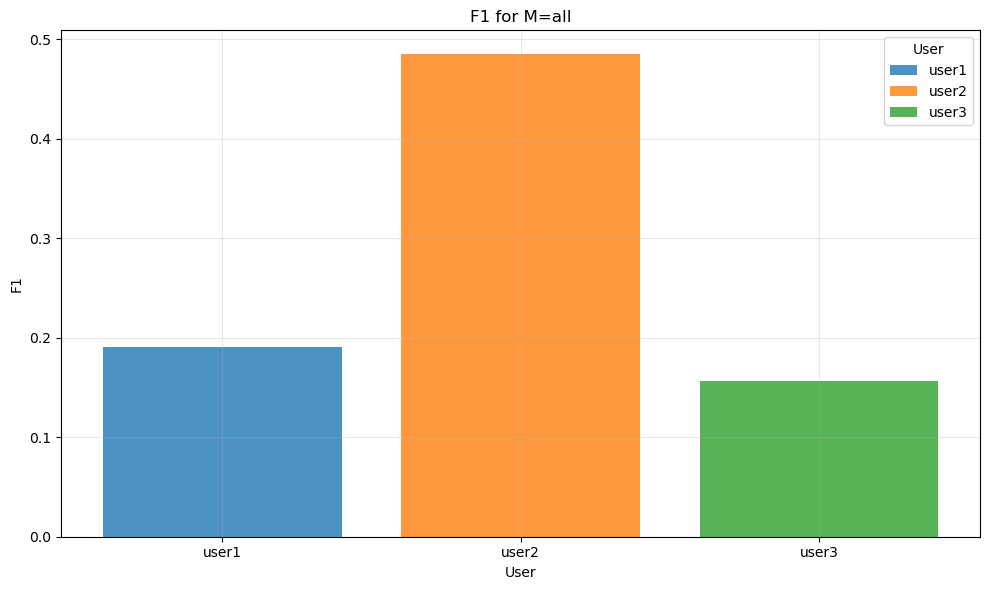

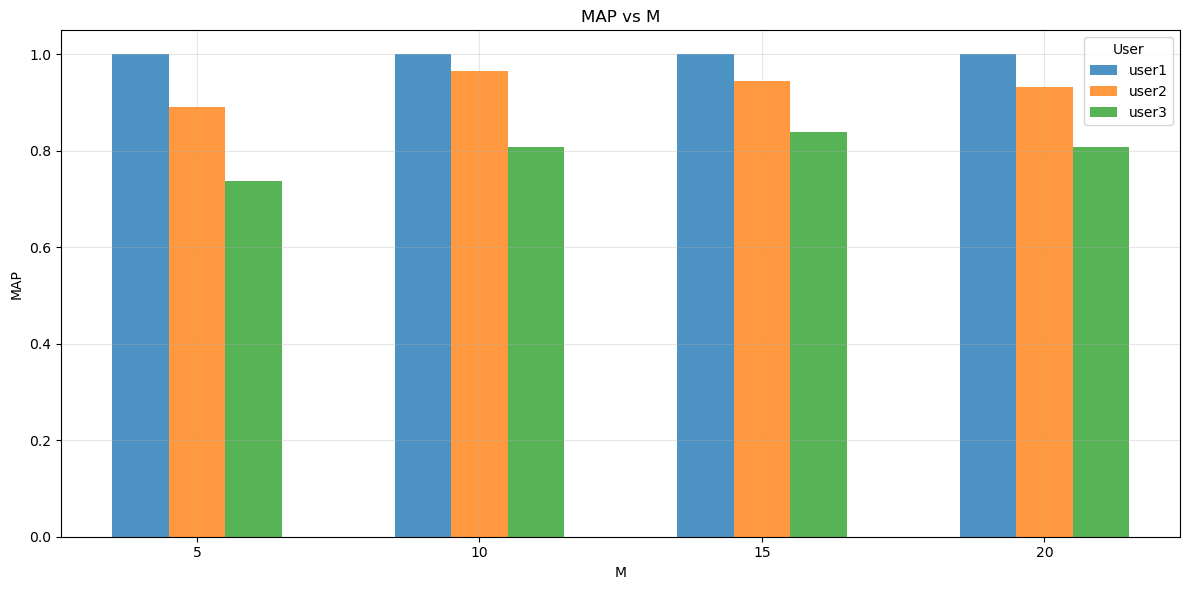

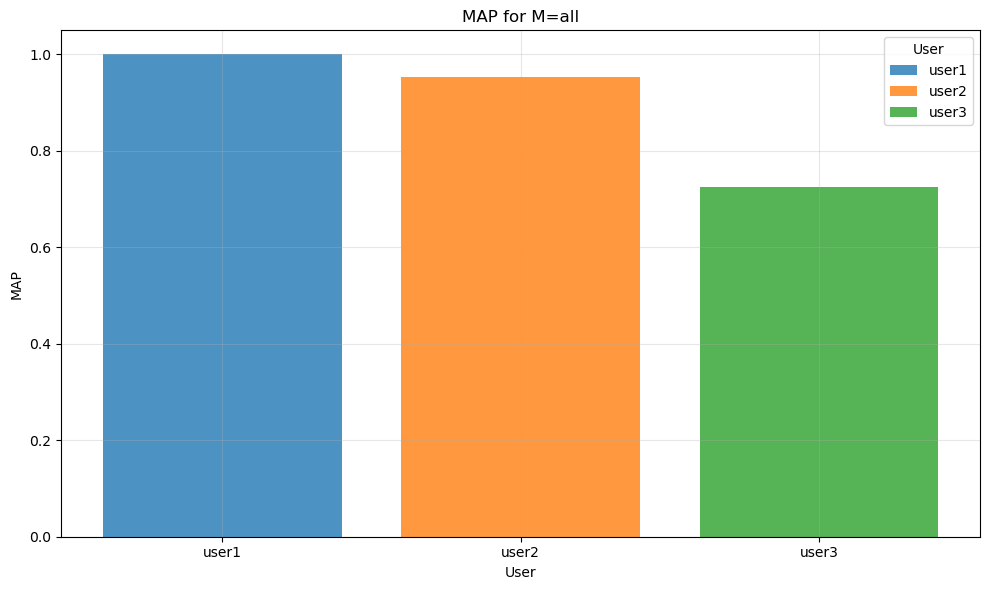

In [28]:
def plot_metrics_comparison(df_result):
    
    df_numeric = df_result[df_result['M'] != 'all'].copy()
    df_all = df_result[df_result['M'] == 'all'].copy()
    metrics = ['Precision', 'Recall', 'F1', 'MAP']
    M_list = sorted(df_numeric['M'].unique())
    user_list = df_numeric['User'].unique()
    
    bar_width = 0.2
    index = np.arange(len(M_list))
    
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        
        for i, user in enumerate(user_list):
            user_data = df_numeric[df_numeric['User'] == user]
            user_data = user_data.sort_values('M')
            values = user_data[metric].values
            bar_positions = index + i * bar_width
            plt.bar(bar_positions, values, bar_width, label=user, alpha=0.8)
        
        plt.title(f'{metric} vs M')
        plt.xlabel('M')
        plt.ylabel(metric)
        plt.xticks(index + bar_width * (len(user_list) - 1) / 2, M_list)
        plt.legend(title='User')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        if not df_all.empty:
            plt.figure(figsize=(10, 6))
            for i, user in enumerate(user_list):
                user_all_data = df_all[df_all['User'] == user]
                if not user_all_data.empty:
                    value = user_all_data[metric].iloc[0]
                    plt.bar(i, value, label=user, alpha=0.8)
            
            plt.title(f'{metric} for M=all')
            plt.xlabel('User')
            plt.ylabel(metric)
            plt.xticks(range(len(user_list)), user_list)
            plt.legend(title='User')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
plot_metrics_comparison(df_result)


### Optimal M Selection

From the plots:
- **Precision** continues to be high for `M=15` and `M=20`, especially for user1 and user3.
- **Recall** slightly increases with larger `M`, up to an optimal of `M=20` for user2.
- **F1-score** (harmonic mean of precision and recall) best balance at `M=20`.
- **MAP** is highest and most stable for `M=15` and `M=20`, which indicates stable overall ranking quality.

I select `M=20` as the best since it achieves:

- High **precision** for all;
- Highest **recall** and **F1** for user2 (with broader interests);
- Consistently high **MAP**, which means that not just correct but highly ranked recommended items are given. 

It reflects that a greater number of top keywords can be covered (up to 20) which allows better coverage of users' interests without compromising recommendation quality.

### Another matching algorithm: weighted keyword matching

In [29]:
def build_user_profile(user_keywords_dict, df, vec, top_m='all', repeat_times=50):

    from sklearn.preprocessing import normalize
    import numpy as np
    from scipy.sparse import csr_matrix
    
    profile = {}
    
    for topic, keywords in user_keywords_dict.items():

        topic_songs = df[df['topic'] == topic]['clean_lyrics'].tolist()
        
        if not topic_songs:
            continue
        
        topic_vec = vec.transform(topic_songs)
        
        avg_vec = topic_vec.mean(axis=0)
        
        feature_names = vec.get_feature_names_out()
        
        if top_m == 'all':
            selected_topic_words = feature_names
        else:
            arr = avg_vec.A[0] if hasattr(avg_vec, 'A') else avg_vec.toarray()[0]
            top_idx = arr.argsort()[::-1][:int(top_m)]
            selected_topic_words = [feature_names[i] for i in top_idx]
        
        keywords_list = list(keywords) if isinstance(keywords, set) else keywords
        user_keywords = [kw for kw in keywords_list if kw in feature_names]
        
        if not user_keywords:
            continue
        
        enhanced_texts = []
        
        enhanced_texts.extend(topic_songs)
        
        for keyword in user_keywords:
            repeated_keyword = ' '.join([keyword] * repeat_times)
            enhanced_texts.append(repeated_keyword)
        
        enhanced_vec = vec.transform(enhanced_texts)
        
        avg_vec_enhanced = enhanced_vec.mean(axis=0)
        
        if top_m != 'all':
            arr_enhanced = avg_vec_enhanced.A[0] if hasattr(avg_vec_enhanced, 'A') else avg_vec_enhanced.toarray()[0]
            
            masked = np.zeros_like(arr_enhanced)
            for word in selected_topic_words:
                if word in feature_names:
                    idx = list(feature_names).index(word)
                    masked[idx] = arr_enhanced[idx]
            
            profile_vec = csr_matrix(masked.reshape(1, -1))
        else:
            profile_vec = avg_vec_enhanced
        
        if hasattr(profile_vec, 'toarray'):
            profile_vec_array = profile_vec.toarray()
        elif hasattr(profile_vec, 'A'):
            profile_vec_array = profile_vec.A
        else:
            profile_vec_array = np.asarray(profile_vec)
        
        if profile_vec_array.ndim == 1:
            profile_vec_array = profile_vec_array.reshape(1, -1)
        
        profile_vec_normalized = normalize(profile_vec_array, norm='l2')
        profile[topic] = profile_vec_normalized
    
    return profile

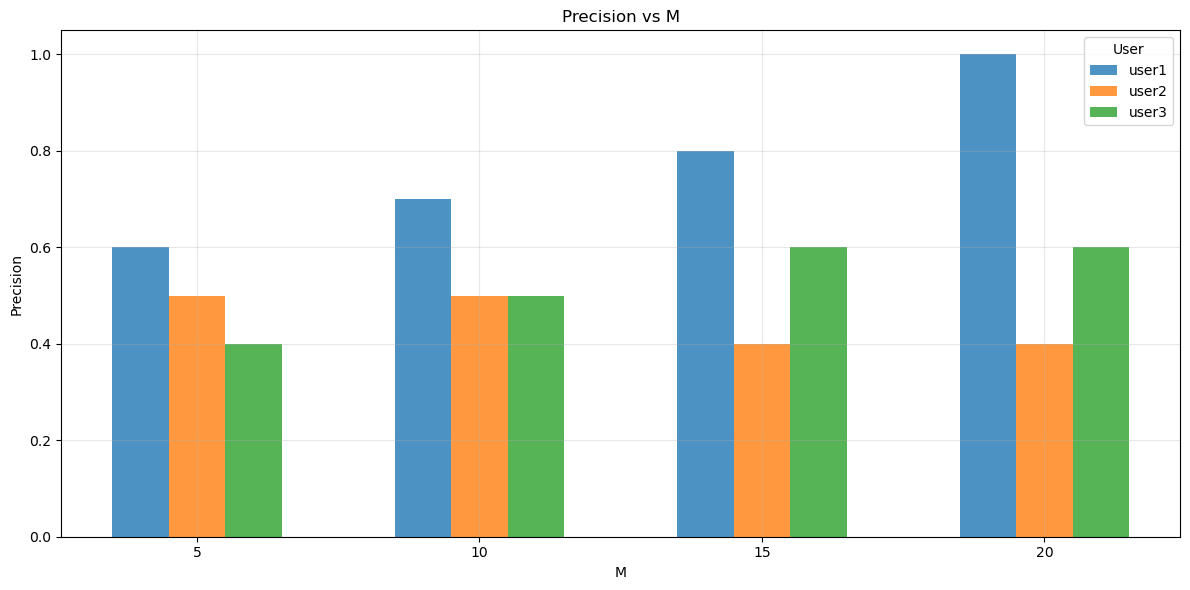

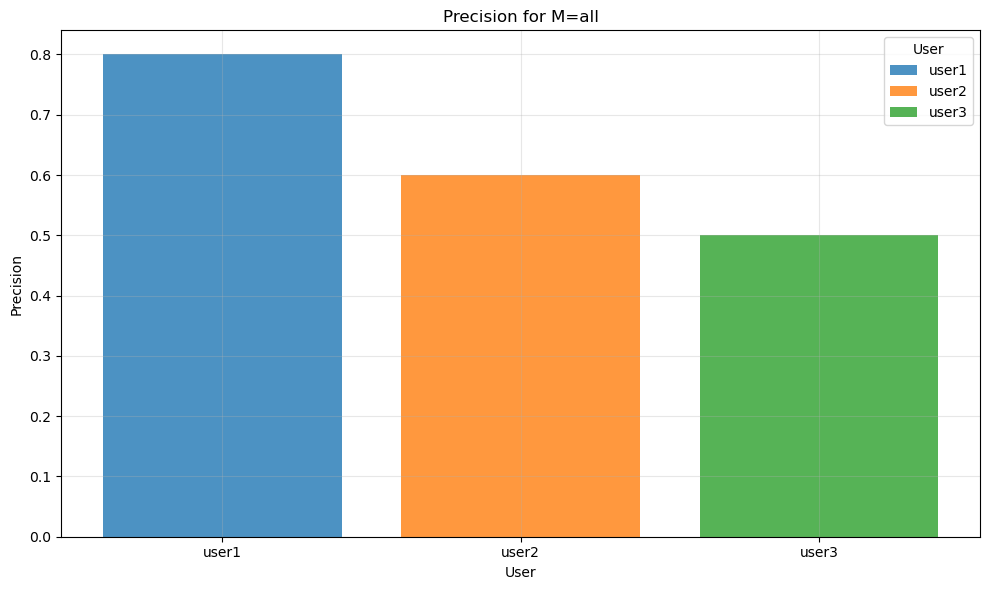

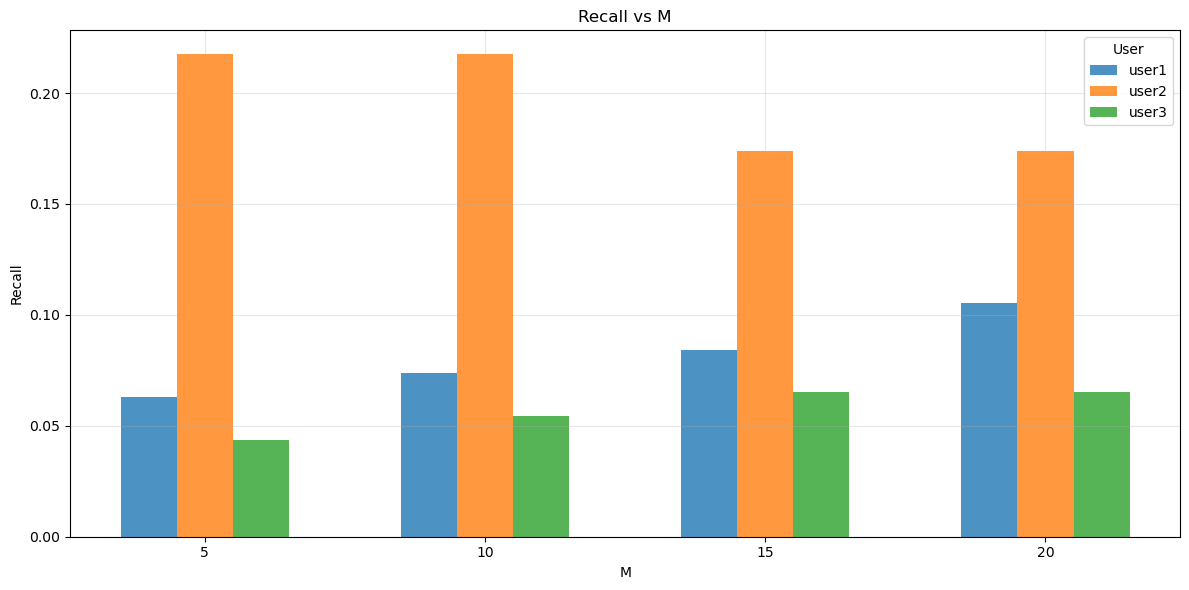

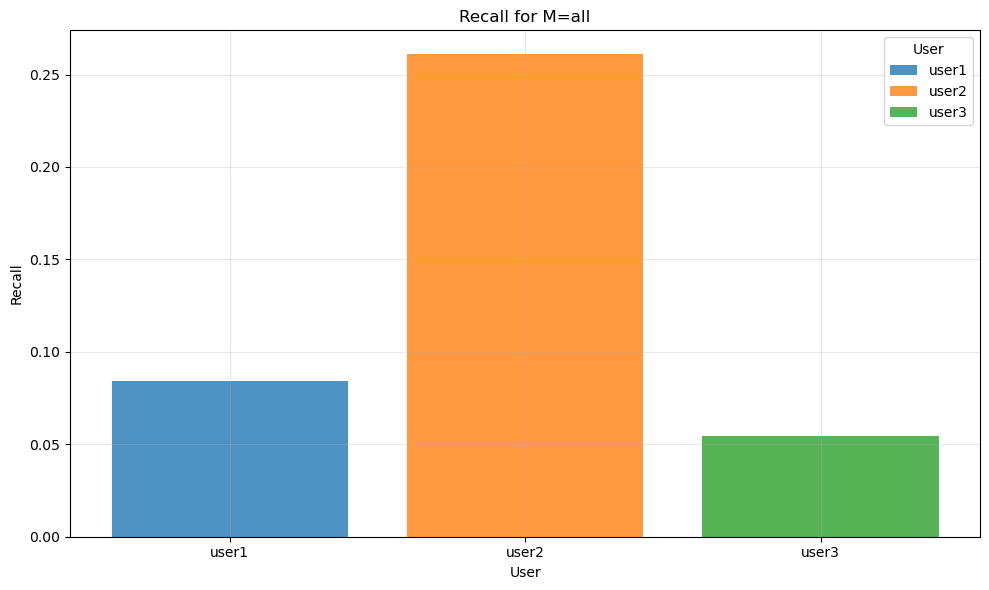

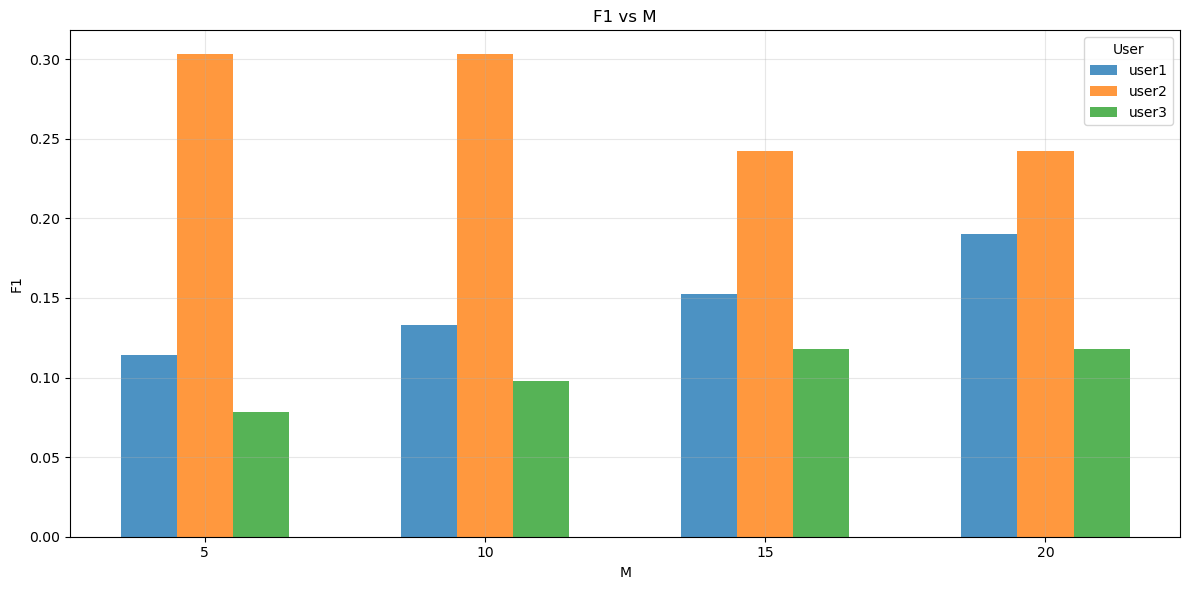

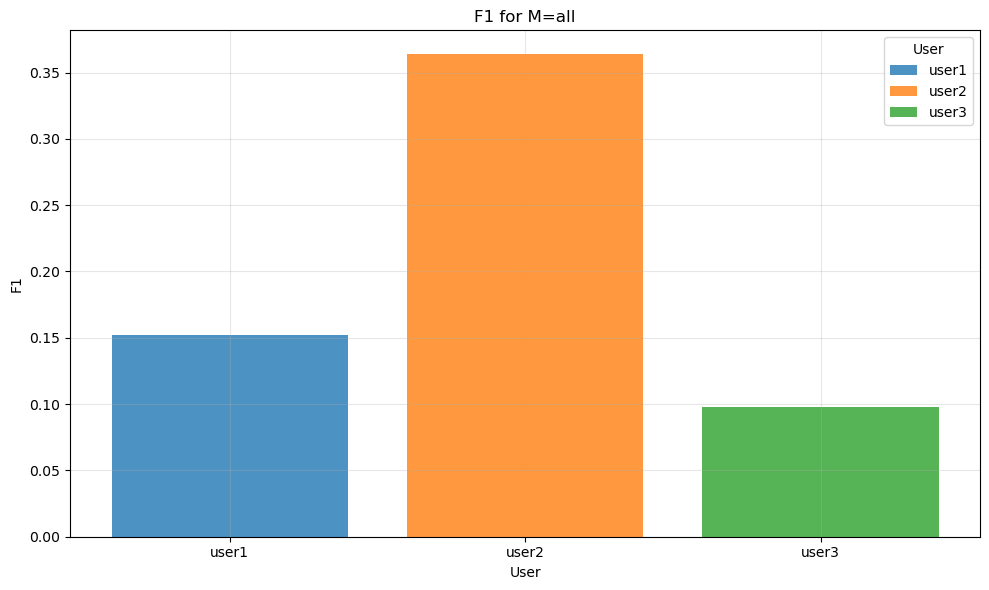

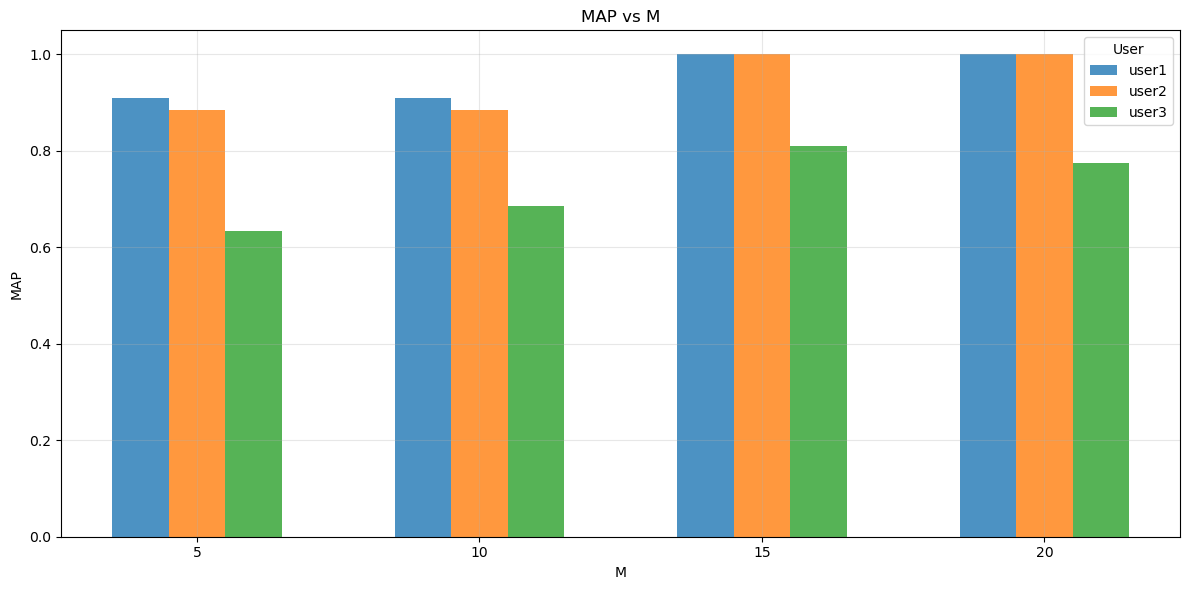

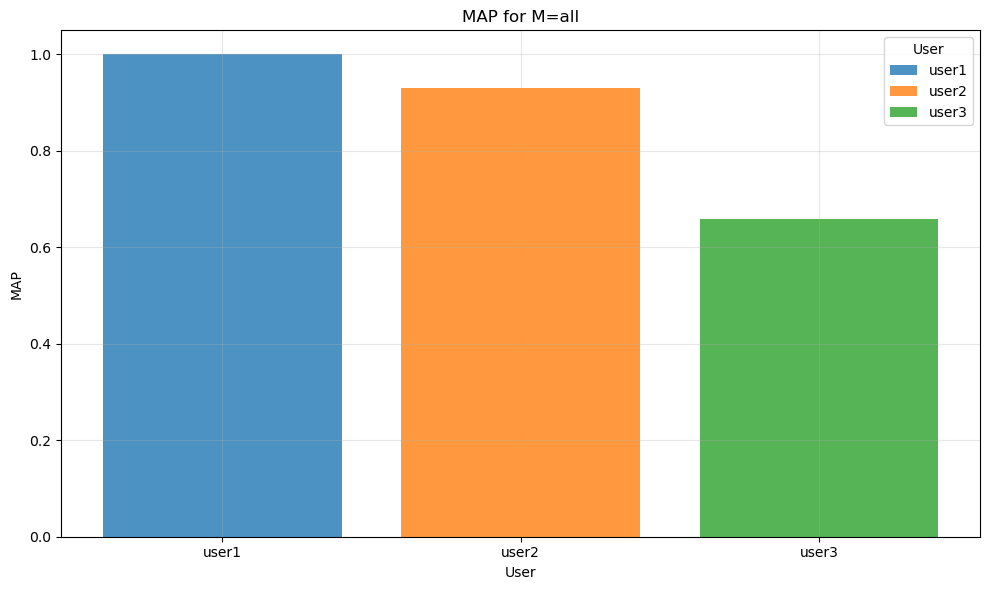

In [30]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

def final_evaluation(M_list, N, user_liked_dicts, train_data, test_data, 
                                  best_vectorizer_tfidf, X_test_vec_tfidf):
    
    results = []
    
    for M in M_list:
        for uid, (liked_dict, liked_songs) in user_liked_dicts.items():
            
            user_profile = build_user_profile(liked_dict, train_data, best_vectorizer_tfidf, top_m=M, repeat_times=50)
    
            sim_scores = compute_similarity_scores(user_profile, X_test_vec_tfidf, test_data['predicted_topic'])

            topN_df = get_top_n_recommendations(test_data, sim_scores)

            precision, recall, f1, map = evaluate_recommendations(topN_df, liked_dict, test_data)
        
            results.append((uid, M, precision, recall, f1, map))

    df_result = pd.DataFrame(results, columns=['User', 'M', 'Precision', 'Recall', 'F1', 'MAP'])
    
    return df_result


M_list = [5, 10, 15, 20, 'all']
N = 10
user_liked_dicts = {
    'user1': (user1_keywords, user1_liked),
    'user2': (user2_keywords, user2_liked),
    'user3': (user3_keywords, user3_liked)
}

df_result = final_evaluation(
    M_list=M_list,
    N=N,
    user_liked_dicts=user_liked_dicts,
    train_data=train_data,
    test_data=test_data,
    best_vectorizer_tfidf=best_vectorizer_tfidf,
    X_test_vec_tfidf=X_test_vec_tfidf
)
plot_metrics_comparison(df_result)

### Matching Algorithm Comparison and Selection

For this project, I experimented with two content matching algorithms:

- **Full-text TF-IDF Cosine Similarity**: Creates user profiles based on the full-text lyrics of songs a user "likes", and computes cosine similarity between the user profile and candidate songs using TF-IDF vectors.
- **Weighted Keyword Matching**: Uses user-provided topic keywords to generate pseudo-documents. The keywords are copied to increase their TF-IDF weights, building a focused user profile that is then used for similarity matching.

#### Comparative Analysis:

- **Accuracy**: Both methods are similar in terms of Precision and MAP, but the weighted keyword method tends to overfit some themes.
- **Diversity**: Full-text TF-IDF considers more contextual information, which results in more diverse recommendation outputs.
- **Stability and Generalization**: The keyword-based approach is highly sensitive to the quality and quantity of input keywords, so it is less stable. By comparison, the full-text approach generalizes better to different structures of user interests.
- **Interpretability**: The keyword-based approach is more interpretable because user profiles directly represent interest keywords.

Therefore, the **most comprehensive and strongest is the full-text TF-IDF cosine similarity method**. It was ultimately chosen as the primary recommendation algorithm due to its ability to model user interests nicely and at the same time offer broader coverage and scalability.


# Part3

### Week1-3: Randomly recommended sample pool

In [37]:
import pandas as pd
import random

df = pd.read_csv("dataset.tsv", sep="\t")

week1_df = df.iloc[0:250].copy()
week2_df = df.iloc[250:500].copy()
week3_df = df.iloc[500:750].copy()
week4_df = df.iloc[750:1000].copy()

N = 10
# Remove random_state to ensure different results each run
week1_random = week1_df.sample(N)
week2_random = week2_df.sample(N)
week3_random = week3_df.sample(N)

In [38]:
user_selections = []

# Week 1 recommendations
print("=== Week 1 Recommended Songs ===")
for idx, row in week1_random.iterrows():
    print(f"Index {idx}: {row['artist_name']} - {row['track_name']} - {row['release_date']} - {row['genre']} - {row['lyrics']} - {row['topic']}")

print("\nEnter the index of songs you like (type 'done' to finish):")
while True:
    user_input = input().strip()
    if user_input.lower() == 'done':
        break
    try:
        song_index = int(user_input)
        if song_index in week1_random.index:
            user_selections.append(song_index)
            print(f"Selected: Index {song_index}")
        else:
            print("Invalid index, please try again")
    except ValueError:
        print("Please enter a valid number or 'done'")

# Week 2 recommendations
print("\n=== Week 2 Recommended Songs ===")
for idx, row in week2_random.iterrows():
    print(f"Index {idx}: {row['artist_name']} - {row['track_name']} - {row['release_date']} - {row['genre']} - {row['lyrics']} - {row['topic']}")

print("\nEnter the index of songs you like (type 'done' to finish):")
while True:
    user_input = input().strip()
    if user_input.lower() == 'done':
        break
    try:
        song_index = int(user_input)
        if song_index in week2_random.index:
            user_selections.append(song_index)
            print(f"Selected: Index {song_index}")
        else:
            print("Invalid index, please try again")
    except ValueError:
        print("Please enter a valid number or 'done'")

# Week 3 recommendations
print("\n=== Week 3 Recommended Songs ===")
for idx, row in week3_random.iterrows():
    print(f"Index {idx}: {row['artist_name']} - {row['track_name']} - {row['release_date']} - {row['genre']} - {row['lyrics']} - {row['topic']}")

print("\nEnter the index of songs you like (type 'done' to finish):")
while True:
    user_input = input().strip()
    if user_input.lower() == 'done':
        break
    try:
        song_index = int(user_input)
        if song_index in week3_random.index:
            user_selections.append(song_index)
            print(f"Selected: Index {song_index}")
        else:
            print("Invalid index, please try again")
    except ValueError:
        print("Please enter a valid number or 'done'")

user_selections = list(set(user_selections))

# Build training dataset
print(f"\nTotal selected: {len(user_selections)} songs")
training_data = df.loc[user_selections].copy()
print("\n=== Training Dataset Song Information ===")
for idx, row in training_data.iterrows():
    print(f"Index {idx}: {row['artist_name']} - {row['track_name']} - {row['release_date']} - {row['genre']} - {row['lyrics']} - {row['topic']}")

print(f"Training dataset size: {len(training_data)} songs")

=== Week 1 Recommended Songs ===
Index 228: sleeping wolf - new kings - 2017 - rock - stand fight need mean second guessin yeah gonna wear crown cause stand fight stop kings ignore like pass raise voice scar scar power come ignore stand fight need lyric commercial - dark
Index 112: madeleine peyroux - shout sister shout - 2016 - jazz - shout sister shout hallelujah shout sister shout shout sister shout tell world reason live reason die darn good reason woman start cry reason mole reason dimple reason simple shout sister shout hallelujah shout sister shout hallelujah shout sister shout mmhmm yeah shout sister shout tell world brilliant fool heaven observe golden rule sweetheart wife quit baby lose life shout sister shout hallelujah shout sister shout hallelujah shout sister shout yeah tell world reason mountain reason reason doctor give patient pill reason dance reason sing reason band swing understand bird understand be understand eat cheese understand understand cat rhythm understand 

In [39]:
training_data["document"] = training_data["artist_name"].fillna("") + " " + \
                 training_data["track_name"].fillna("") + " " + \
                 training_data["genre"].fillna("") + " " + \
                 training_data["lyrics"].fillna("")
training_data.reset_index(drop=True, inplace=True)
training_data["clean_lyrics"] = training_data["lyrics"].apply(lambda x: preprocess(x, True, False, True, True))
training_data["clean_text"] = training_data["document"].apply(lambda x: preprocess(x, True, False, True, True))

week4_df["document"] = week4_df["artist_name"].fillna("") + " " + \
                 week4_df["track_name"].fillna("") + " " + \
                 week4_df["genre"].fillna("") + " " + \
                 week4_df["lyrics"].fillna("")
week4_df.reset_index(drop=True, inplace=True)
week4_df["clean_text"] = week4_df["document"].apply(lambda x: preprocess(x, True, False, True, True))

### Build user profile

In [40]:
X_liked_vec = best_vectorizer_tfidf.transform(training_data['clean_text'])
training_data['predicted_topic'] = best_clf.predict(X_liked_vec)

def build_user_profile_from_df(df, vec):
    profile_dict = {}
    for topic in ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']:
        topic_docs = df[df['predicted_topic'] == topic]['clean_text']
        profile_text = ' '.join(topic_docs)
        profile_vec = vec.transform([profile_text])
        profile_dict[topic] = profile_vec
    return profile_dict

user_x_profile = build_user_profile_from_df(training_data, best_vectorizer_tfidf)

### Real user feedback for Week4

In [41]:
X_week4_vec = best_vectorizer_tfidf.transform(week4_df['clean_text'])
week4_df['predicted_topic'] = best_clf.predict(X_week4_vec)

sim_scores = compute_similarity_scores(user_x_profile, X_test_vec_tfidf, week4_df['predicted_topic'])

topN_df = get_top_n_recommendations(test_data, sim_scores)

for i, (_, row) in enumerate(topN_df.iterrows(), 1):
    print(f"Index {i}: {row['artist_name']} - {row['track_name']} - {row['release_date']} - {row['genre']} - {row['lyrics']} - {row['topic']}")
    print()

user_real_liked_songs = []

print("\nEnter the index of songs you like (type 'done' to finish):")
while True:
    user_input = input().strip()
    if user_input.lower() == 'done':
        break
    try:
        song_index = int(user_input)
        if song_index in topN_df.index + 1:
            user_real_liked_songs.append(song_index - 1)
            print(f"Selected: Index {song_index}")
        else:
            print("Invalid index, please try again")
    except ValueError:
        print("Please enter a valid number or 'done'")

Index 1: justin moore - got it good - 2016 - country - wake morning warn little bounce blue eye start pillow talk twist sheet finger walk hell start yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right turn kitchen light cork drink wine right outta bottle babe spin white noise record play little gaye minute bedroom bind yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right good morning good late night good thing go good right yeah good sure good see smile kiss eye hips whoah tell like good good sure good good morning good late night good thing go good right - emotion

Index 2: the detroit cobras - shout bamalama - 2016 - blues - alabama shout bamalama louisiana go lord soul chickens steal night night go unintelligible chicken baby shout bamalama go feet feet go feild feet step feet heel feet swing knock feet grin teeth fell ton

In [42]:
def evaluate_real_user_feedback(recommendations, liked_indices):
    hits = [1 if i in liked_indices else 0 for i in range(len(recommendations))]
    precision = sum(hits) / len(hits)
    recall = sum(hits) / len(liked_indices) if len(liked_indices) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    ap = sum([hits[i] * (sum(hits[:i+1]) / (i+1)) for i in range(len(hits))]) / max(1, sum(hits))
    return precision, recall, f1, ap

precision, recall, f1_score, map_score = evaluate_real_user_feedback(topN_df, user_real_liked_songs)

print(f"Precision@N: {precision:.4f}")
print(f"Recall@N: {recall:.4f}")
print(f"F1@N: {f1_score:.4f}")
print(f"MAP@N: {map_score:.4f}")

Precision@N: 0.8000
Recall@N: 1.0000
F1@N: 0.8889
MAP@N: 0.8228


### User Feedback and Recommendation Performance Analysis

#### User Comment

"I like emotional and personal lyrics more. Songs No. 2, 3, and 6 really touched me — they express inner feelings or sufferings of coming of age in life. The ones with more 'negatives' in them, on the other hand, seemed superficial to me, and I bypassed them quickly. Overall, the recommended songs this time were quite close to what I prefer, especially some of the songs in the middle section of the Week 4 list — they hit the spot really well."

#### Recommendation Metrics

| Metric     | Value  |
|------------|--------|
| Precision@N | 0.8000 |
| Recall@N    | 1.0000 |
| F1@N        | 0.8889 |
| MAP@N       | 0.8228 |

The above Recall@N is a hypothetical best case and not really dependable. Since I can only view the user's response from among the Top-N recommended songs, but can't obtain the entire list of songs the user actually liked from all Week 4 test set (250 songs), the recall calculation assumes all the liked songs are within the recommended list. That is too idealized an assumption and fails in real-world cases.

#### Analysis and Comparison

As opposed to keyword-driven simulated user profiles for Part 2, the user profile developed in Part 3 from real preferences is more precise. The user certainly favored "emotion" and "personal" headed lyrics for the first three weeks, and the recommendation system could focus the Week 4 results on those subjects, indicating good interest modeling. However, obvious constraints remain: with lyrics of same words, the users may not enjoy certain songs due to some differences in rhythm or tone. Therefore, basic TF-IDF similarity cannot always capture genuine preferences.

#### Summary

The real-user experiment verifies the correctness of the system in topic matching but also indicates its shortcoming in expressing emotions and style diversity. Future work can incorporate audio features or emotion modeling to enhance recommendation quality.